# Question 1

In [1]:
# Initialize Spark Session 
# Spark session builder
# For Spark 2.X, SparkSession become an entry point to PySpark to work with RDD (resiliant distributed database), and DataFrame.

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName('SparkTest').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/28 13:17:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Spark context access the hardware-level and software-leve configuration 
# For Spark 2.X
# Spark Session provides a unified interface for interacting with 
# different Spark APIs and allows applications to run on a Spark cluster. 

import pyspark
from pyspark import SparkContext, SQLContext 

appName = "Big Data Analytics"
master = "local"

### Create Configuration object for Spark.
# setAppName: set the name of the application 
# setMaster: set Spark cluster to use, here "local" indicating local machine
# set("setting configuration", "attribute"): The configuration could be "spark.driver.host" or "spark.executor.memory"
# and the second entry indicating the corresponding configuration 

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master) 

# Create Spark Context with the new configurations rather than relying on the default one
# SparkContext 
sc = SparkContext.getOrCreate(conf=conf) # getOrCreate get the current configuration or create a new one

# Linking to SQL API
# You need to create SQL Context to conduct some database operations like what we will see later.
# SQLContext

sqlContext = SQLContext(sc) # Connected to SQL API




/Users/tungyuhsiao/opt/anaconda3/envs/ipynb_env/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# 
# Load data from csv to a dataframe on a local machine. 
# header=False means the first row is not a header 
# sep=',' means the column are seperated using ','
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

df = spark.read.csv("/Users/tungyuhsiao/Documents/MS Fall 2023/14763 SYS/data/NSL-KDD/KDDTrain+.txt",header=False, inferSchema= True).toDF(*col_names)


In [4]:
df.printSchema()


root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [5]:
from pyspark.sql.functions import monotonically_increasing_id
df = df.withColumn("id", monotonically_increasing_id())
df.show()

+--------+-------------+----------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------+----------------+---+
|duration|protocol_type|   service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_

23/09/28 13:18:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Question 2

In [6]:
print('creating dynamodb resource')
import boto3
dynamodb = boto3.resource(
    'dynamodb',
    endpoint_url='http://localhost:8000', ### This is the URL for my DynamoDB docker container
    region_name='Global', ### This is a bit ugly but you have to specify valid AWS region for this code to work!
    aws_access_key_id='awskey',
    aws_secret_access_key='awskey',
    verify=False)

print ('got resource:', dynamodb) ## This is a confirmation that I'm able to connect to DynamoDB without problems 

creating dynamodb resource
got resource: dynamodb.ServiceResource()


In [7]:
from decimal import Decimal
spark = SparkSession.builder \
    .appName("Write to DynamoDB") \
    .config("spark.serializer", "org.apache.spark.serializer.PyroSerializer") \
    .getOrCreate()


# Create an empty dynamodb table
table_name = "KDD"
table = dynamodb.Table(table_name)
print(table)
# delete the table if it exists
try:
    table.delete()
except Exception as e:
    print(e)

# Indicate Keyschema
try:
    result = dynamodb.create_table( ### Now, I'm creating the table
        TableName=table_name,
        # The only thing we have to define is the key 
        # DynamoDB is not completely schemaless, but do need to define a key 
        KeySchema=[
            {
                'AttributeName': 'id',
                'KeyType': 'HASH'  # Partition key
            }
        ],
        AttributeDefinitions=[
            {
                'AttributeName': 'id',
                'AttributeType': 'N' # N is for number
            }
        ],
        ProvisionedThroughput={
            'ReadCapacityUnits': 1,
            'WriteCapacityUnits': 1
        }
    )
    print('Created table:', result)
except: 
    print('There is a problem with the table creation. Try again later!')

table = dynamodb.Table(table_name)
print('got table:', table)


# Write Pyspark df to json file
import json
json_df = df.toJSON().collect()

# Wrting json file that store Pyspark df into dynamodb table row by row
with table.batch_writer() as batch:
    for row in json_df:
        item = json.loads(row, parse_float=Decimal)
        batch.put_item(Item=item)






23/09/28 13:18:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


dynamodb.Table(name='KDD')
Created table: dynamodb.Table(name='KDD')
got table: dynamodb.Table(name='KDD')


In [8]:
# Retrieve all records

response = table.scan()
print(response.get('Items', [])[0])



{'dst_host_srv_rerror_rate': Decimal('1'), 'same_srv_rate': Decimal('0.02'), 'flag': 'REJ', 'num_file_creations': Decimal('0'), 'srv_serror_rate': Decimal('0'), 'classes': 'neptune', 'dst_host_same_src_port_rate': Decimal('0'), 'hot': Decimal('0'), 'duration': Decimal('0'), 'num_root': Decimal('0'), 'src_bytes': Decimal('0'), 'dst_host_same_srv_rate': Decimal('0.02'), 'num_shells': Decimal('0'), 'dst_host_rerror_rate': Decimal('1'), 'land': Decimal('0'), 'id': Decimal('34359740770'), 'urgent': Decimal('0'), 'num_access_files': Decimal('0'), 'num_compromised': Decimal('0'), 'dst_bytes': Decimal('0'), 'num_outbound_cmds': Decimal('0'), 'num_failed_logins': Decimal('0'), 'is_host_login': Decimal('0'), 'srv_count': Decimal('6'), 'difficulty_level': Decimal('18'), 'srv_rerror_rate': Decimal('1'), 'root_shell': Decimal('0'), 'su_attempted': Decimal('0'), 'dst_host_srv_diff_host_rate': Decimal('0'), 'dst_host_srv_count': Decimal('6'), 'logged_in': Decimal('0'), 'count': Decimal('261'), 'dst_h

# Question 3

In [9]:
# Search Items
from boto3.dynamodb.conditions import Attr
import random 

DoS = ["apache2", "back", "land", "neptune", "mailbomb", 
           "pod", "processtable", "smurf", "teardrop", "upstorm", "worm"]

def scan_items_in_classes(items:list):
    # setup scan_kwargs 
    scan_kwargs = {
        # Use attribute to scan and filter items
        # Attr(scanned_column).is_in(iterable)
        "FilterExpression": Attr("classes").is_in(items)
    }
    response = table.scan(**scan_kwargs)
    all_items = response.get("Items", [])
    print(all_items[0])

scan_items_in_classes(DoS)



{'dst_host_srv_rerror_rate': Decimal('1'), 'same_srv_rate': Decimal('0.02'), 'flag': 'REJ', 'num_file_creations': Decimal('0'), 'srv_serror_rate': Decimal('0'), 'classes': 'neptune', 'dst_host_same_src_port_rate': Decimal('0'), 'hot': Decimal('0'), 'duration': Decimal('0'), 'num_root': Decimal('0'), 'src_bytes': Decimal('0'), 'dst_host_same_srv_rate': Decimal('0.02'), 'num_shells': Decimal('0'), 'dst_host_rerror_rate': Decimal('1'), 'land': Decimal('0'), 'id': Decimal('34359740770'), 'urgent': Decimal('0'), 'num_access_files': Decimal('0'), 'num_compromised': Decimal('0'), 'dst_bytes': Decimal('0'), 'num_outbound_cmds': Decimal('0'), 'num_failed_logins': Decimal('0'), 'is_host_login': Decimal('0'), 'srv_count': Decimal('6'), 'difficulty_level': Decimal('18'), 'srv_rerror_rate': Decimal('1'), 'root_shell': Decimal('0'), 'su_attempted': Decimal('0'), 'dst_host_srv_diff_host_rate': Decimal('0'), 'dst_host_srv_count': Decimal('6'), 'logged_in': Decimal('0'), 'count': Decimal('261'), 'dst_h

# Question 4

In [10]:
from collections import Counter
# Search for the most popular items
# What is the Key element in the data and what is non-key element

# its returning nothing
def column_unique(col_name:str):
    scan_kwargs = {
        # Use attribute to scan and filter items
        # Attr(scanned_column).is_in(iterable)
        "ProjectionExpression": col_name
    }
    response = table.scan(**scan_kwargs)

    values = [item.get(col_name) for item in response.get("Items", [])]
    
    # Filter out None values and return the unique set
    unique_values = set(value for value in values if value is not None)
    return unique_values
protocal_type = column_unique("protocol_type")
print(protocal_type)


{'tcp', 'udp', 'icmp'}


In [16]:
from confluent_kafka import Producer
import socket
#Initialize Your Parameters here - Keep the variable values as is for the ones you can't find on the Confluent-Kafka connection 
KAFKA_CONFIG = {
    "bootstrap.servers":"pkc-lzvrd.us-west4.gcp.confluent.cloud:9092",
    "security.protocol":"SASL_SSL",
    "sasl.mechanisms":"PLAIN",
    "sasl.username":"HL23UZFPCOPP6LMM",
    "sasl.password":"Wav0hcLDdJ1a/ACVuw7Ifj+rjb6k+vkJuMXcj6zpISgQGGZZwWNx1xRwl2fRZKc8",
    "session.timeout.ms":"45000",
    "group.id":"python-group-1",
    'auto.offset.reset': 'smallest',
    'client.id': socket.gethostname()
}

# Update your topic name
topic_name = "topic_test"
producer = Producer(KAFKA_CONFIG)


%4|1695921932.411|CONFWARN|oneofdaskidneys.wifi.local.cmu.edu#producer-3| [thrd:app]: Configuration property group.id is a consumer property and will be ignored by this producer instance
%4|1695921932.411|CONFWARN|oneofdaskidneys.wifi.local.cmu.edu#producer-3| [thrd:app]: Configuration property session.timeout.ms is a consumer property and will be ignored by this producer instance
%4|1695921932.411|CONFWARN|oneofdaskidneys.wifi.local.cmu.edu#producer-3| [thrd:app]: Configuration property auto.offset.reset is a consumer property and will be ignored by this producer instance


In [17]:
import feedparser
# Producer
# We are searching for Analytics in the news
feed_url = "https://news.google.com/rss/search?q=tcp+udp+icmp"
def extract_news_feed(feed_url):
    feed = feedparser.parse(feed_url)
    articles = []
    extracted_articles = set()
    for entry in feed.entries:
        
        link = entry.link
        title = entry.title.encode('ascii', 'ignore').decode()
        unique_id = f'{link}-{title}'
        if unique_id in extracted_articles:
            continue
        extracted_articles.add(unique_id)
        article_data = {"title": title, "link":link}
        if article_data is not None:
            producer.produce(topic_name, key=article_data["title"], value=article_data["link"])
    producer.flush()

    
extract_news_feed(feed_url)

In [18]:
# Consumer Pull 
from confluent_kafka import Consumer
from pyspark.sql.types import *
import string
import time


# Clean the punctation by making a translation table that maps punctations to empty strings
translator = str.maketrans("", "", string.punctuation)


emp_RDD = spark.sparkContext.emptyRDD()
# Defining the schema of the DataFrame
columns = StructType([StructField('key', StringType(), False),
                      StructField('value', StringType(), False)])

# Creating an empty DataFrame
df_news = spark.createDataFrame(data=emp_RDD,
                                   schema=columns)
 
# Printing the DataFrame with no data
df_news.show()

consumer = Consumer(KAFKA_CONFIG)
consumer.subscribe([topic_name])

end_time = time.time() + 120 # second

try:
    i = 0
    while time.time() <= end_time:
        msg = consumer.poll(timeout=1.0)
        if msg is None:
            i = i + 1
            print("Waiting...")
            continue
        if msg is not None:
            key = msg.key().decode('utf-8').lower().translate(translator)
            cleaned_key = " ".join(key.split())
            value = msg.value().decode('utf-8')
            added_row = [[cleaned_key,value]]
            added_df = spark.createDataFrame(added_row, columns)
            df_news = df_news.union(added_df)

except KeyboardInterrupt: 
    pass
finally:
    consumer.close()
    df_news.show()

+---+-----+
|key|value|
+---+-----+
+---+-----+

Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiti

+--------------------+--------------------+
|                 key|               value|
+--------------------+--------------------+
|ping of death fre...|https://news.goog...|
|novel andoryubot ...|https://news.goog...|
|any port in a sto...|https://news.goog...|
|    linuxtcpipx csdn|https://news.goog...|
|100 top ethical h...|https://news.goog...|
|dissecting and ex...|https://news.goog...|
|10 essential linu...|https://news.goog...|
|zerobot botnet em...|https://news.goog...|
|           alex csdn|https://news.goog...|
|                csdn|https://news.goog...|
|5 items to monito...|https://news.goog...|
|a guide to using ...|https://news.goog...|
|this is how the e...|https://news.goog...|
|understanding net...|https://news.goog...|
|9 types of networ...|https://news.goog...|
|packetfiltering f...|https://news.goog...|
|new reptile rootk...|https://news.goog...|
|linuxtcpdumpbyxda...|https://news.goog...|
|12 common network...|https://news.goog...|
|what are firewall...|https://ne

In [20]:
# filter 
from pyspark.sql.functions import *


# Filter items in the column key that contains words in protocal_type
# "~" means excluding: .filter(~col('word').isin(stop_words)) -> excluding words in stop_words

streamed_data = df_news.withColumn('word', explode(split(col('key'), ' '))) \
                .filter(col('word').isin(protocal_type)) \
                .groupBy('word') \
                .count() \
                .sort('count', ascending=False)
    
streamed_data.show()


+----+-----+
|word|count|
+----+-----+
|icmp|    5|
| tcp|    4|
| udp|    3|
+----+-----+



# Question 5

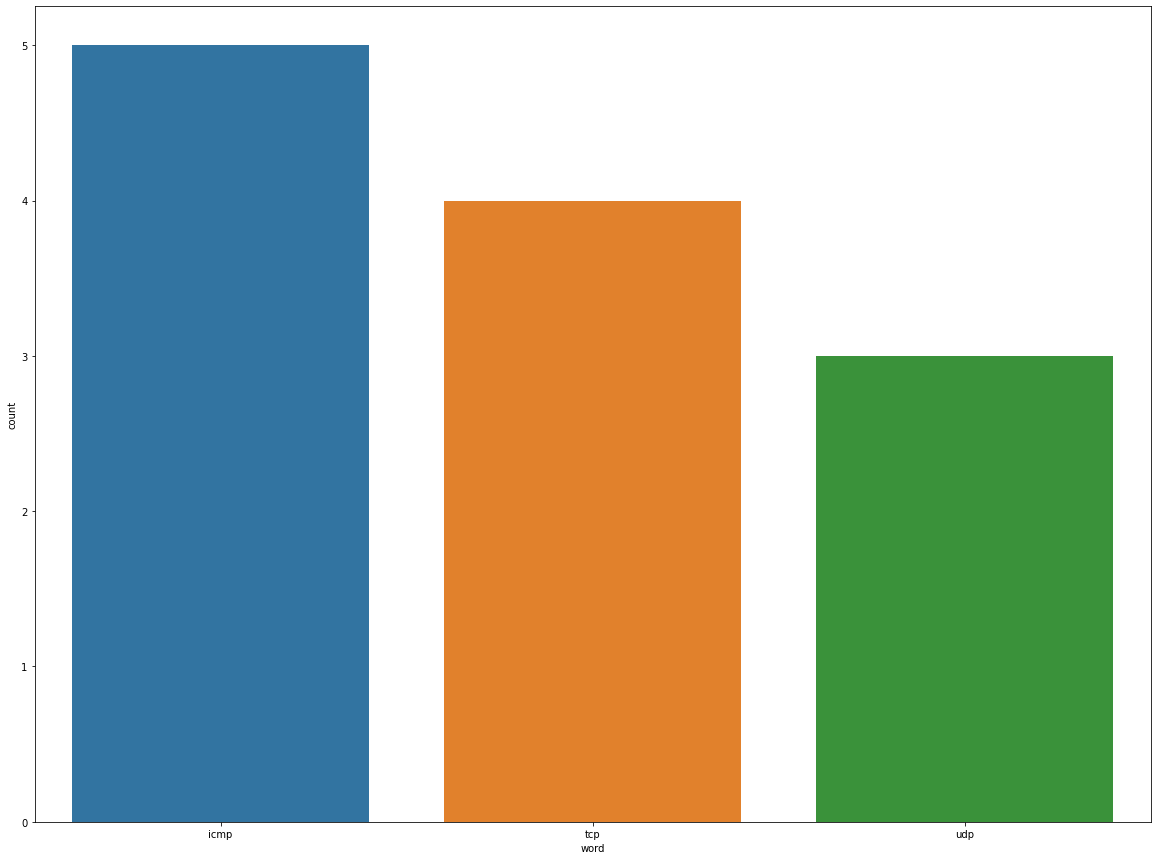

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
top_5_dataframes = streamed_data.orderBy("count",ascending=False).limit(5).toPandas()
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="count", data=top_5_dataframes)
plt.show()